In [1]:
%%html
<style type='text/css'>
.CodeMirror{
    font-size: 16px;
    font-family: Monaco;
}

div.output_area pre {
    font-size: 12px;
}
</style>

In [2]:
# import os
# os.chdir(os.getcwd()+"./..")

In [3]:
# import libaries
import torch
from torch import cuda
from torch.utils.data import Dataset,DataLoader

In [4]:
print(torch.__version__)

1.9.0a0+gitd69c22d


In [5]:
import os
import json
import random
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from collections import Counter

In [6]:
# !pip install transformers

In [7]:
import torch

In [8]:
from transformers import AutoTokenizer

# 1) Import Data

In [9]:
def read_qnli_data(file_name, data_dir):
    path = os.path.join(data_dir, file_name)
    with open(path, encoding='utf-8-sig') as f:
        text = f.readlines()

    header = text[0].strip().split("\t")
    lines = [line.strip().split("\t") for line in text[1:]]

    df = pd.DataFrame(lines, columns=header)
    return df


def get_qnli_pandas_dataframe(data_dir):
    qnli_train_df = read_qnli_data("train.tsv",data_dir)
    qnli_dev_df = read_qnli_data("dev.tsv",data_dir)
    qnli_train_df['label'] = np.where(
        qnli_train_df['label'] == 'entailment', 1, 0)
    qnli_dev_df['label'] = np.where(qnli_dev_df['label'] == 'entailment', 1, 0)

    qnli_dev_df['question'] = qnli_dev_df['question'].apply(lambda x: x.strip())
    qnli_dev_df['sentence'] = qnli_dev_df['sentence'].apply(lambda x: x.strip()) 

    qnli_train_df['question'] = qnli_train_df['question'].apply(lambda x: x.strip())
    qnli_train_df['sentence'] = qnli_train_df['sentence'].apply(lambda x: x.strip()) 

    return qnli_dev_df, qnli_train_df


def read_document_to_list(document_path):
    with open(document_path, encoding='utf-8-sig') as f:
        document = f.readlines()
        sentence_list = [line.strip()
                         for line in document if len(line.strip()) != 0]
        return sentence_list


def read_document_dict(document_dir):

    document_dict = {}

    for document_file_name in os.listdir(document_dir):
        if document_file_name.endswith(".txt"):
            document_name = document_file_name.replace(
                ".txt", "").replace("_", " ")
            document_path = os.path.join(document_dir, document_file_name)
            document_dict[document_name] = read_document_to_list(document_path)

    return document_dict


def read_json(file_path):
    with open(file_path) as f:
        json_f = json.load(f)
    data = json_f['data']
    return data


def get_random_index(List):
    return random.sample(range(len(List)), 1)[0]


def load_data(data_path, load_impossible_answer=False):

    data = read_json(data_path)

    data_dict = {}
    title_list = []
    context_list = []
    question_list = []
    id_list = []
    answer_text_list = []
    answer_start_list = []
    is_impossible_list = []

    for paragraphs in data:
        title = paragraphs['title']
        context_qas_list = paragraphs['paragraphs']

        for context_qas in context_qas_list:
            context = context_qas['context']
            qas_list = context_qas['qas']

            for qas in qas_list:
                title_list.append(title)
                context_list.append(context)

                is_impossible = qas['is_impossible']
                is_impossible_list.append(is_impossible)

                id_ = qas['id']
                id_list.append(id_)
                question = qas['question']
                question_list.append(question)

                if not is_impossible:
                    answer_list = qas['answers']
                    idx = get_random_index(answer_list)
                    answer_text = answer_list[idx]['text']
                    answer_start = answer_list[idx]['answer_start']

                    answer_text_list.append(answer_text)
                    answer_start_list.append(answer_start)
                else:
                    if load_impossible_answer:
                        answer_list = qas['plausible_answers']
                        idx = get_random_index(answer_list)
                        answer_text = answer_list[idx]['text']
                        answer_start = answer_list[idx]['answer_start']
                        answer_text_list.append(answer_text)
                        answer_start_list.append(answer_start)
                    else:
                        answer_text_list.append("")
                        answer_start_list.append(-1)

    data_dict['id'] = id_list
    data_dict['title'] = title_list
    data_dict['context'] = context_list
    data_dict['question'] = question_list
    data_dict['answer_text'] = answer_text_list
    data_dict['answer_start'] = answer_start_list
    data_dict['is_impossible'] = is_impossible_list

    return data_dict


def get_squad_v2_pandas_dataframe(squad_v2_dir,include_impossible=False, load_impossible_answer=False):
    # download from https://rajpurkar.github.io/SQuAD-explorer/
    train_data_path = os.path.join(squad_v2_dir, "train-v2.0.json")
    dev_data_path = os.path.join(squad_v2_dir, 'dev-v2.0.json')

    train_data_dict = load_data(train_data_path, load_impossible_answer)
    dev_data_dict = load_data(dev_data_path, load_impossible_answer)

    train_data_df = pd.DataFrame(train_data_dict)
    dev_data_df = pd.DataFrame(dev_data_dict)

    if not include_impossible:
        train_data_df = train_data_df[train_data_df['is_impossible'] == False]
        dev_data_df = dev_data_df[dev_data_df['is_impossible'] == False]

    train_data_df['question'] = train_data_df['question'].apply(lambda x: x.strip())
    train_data_df['context'] = train_data_df['context'].apply(lambda x: x.strip()) 

    dev_data_df['question'] = dev_data_df['question'].apply(lambda x: x.strip())
    dev_data_df['context'] = dev_data_df['context'].apply(lambda x: x.strip()) 

    return train_data_df, dev_data_df


In [10]:
device = "cuda" if cuda.is_available() else "cpu"

In [11]:
device

'cuda'

In [12]:
model_name ="albert-base-v2"

In [13]:
# qnli_dev_df, qnli_train_df = get_qnli_pandas_dataframe()

In [14]:
# qnli_train_df.head()

In [15]:
# qnli_train_df['question_sentence'] = qnli_train_df.apply(lambda x:  " ".join([x['question'],x['sentence']]),axis = 1)

# qnli_train_df['question_sentence_length'] = qnli_train_df['question_sentence'].apply(lambda x: len(x.split(" ")))

# max(qnli_train_df['question_sentence_length'])

In [16]:
os.listdir("/data/SQUAD2")

['__pycache__', 'dev-v2.0.json', 'evaluate.py', 'train-v2.0.json']

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

squad_v2_dir = "/data/SQUAD2" # data folder

In [18]:
squad_train_df, squad_dev_df = get_squad_v2_pandas_dataframe(squad_v2_dir,include_impossible=True,load_impossible_answer=False)

In [19]:
squad_train_df['question_context'] = squad_train_df.apply(lambda x:  " ".join([x['question'].strip(),x['context'].strip()]),axis = 1)

In [20]:
squad_train_df['question_context_length'] = squad_train_df['question_context'].apply(lambda x: len(x.split(" ")))

In [21]:
max(squad_train_df['question_context_length'])

668

In [22]:
import matplotlib.pyplot as plt

(array([1.9104e+04, 8.0095e+04, 2.3932e+04, 5.4880e+03, 1.3110e+03,
        2.5600e+02, 8.0000e+01, 2.4000e+01, 1.4000e+01, 1.5000e+01]),
 array([ 25. ,  89.3, 153.6, 217.9, 282.2, 346.5, 410.8, 475.1, 539.4,
        603.7, 668. ]),
 <BarContainer object of 10 artists>)

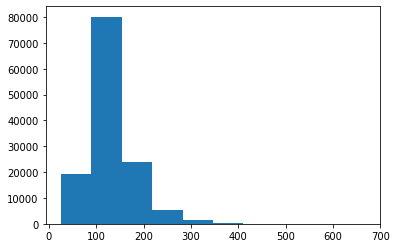

In [23]:
plt.hist(squad_train_df['question_context_length'])

In [24]:
len(squad_train_df[squad_train_df['question_context_length']>=512])

33

In [25]:
squad_train_df['label'] = squad_train_df['is_impossible'].map({False:1,True:0})

In [26]:
squad_dev_df['label'] = squad_dev_df['is_impossible'].map({False:1,True:0})

In [27]:
squad_train_df.head()

,id,title,context,question,answer_text,answer_start,is_impossible,question_context,question_context_length,label
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,False,When did Beyonce start becoming popular? Beyon...,115,1
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,False,What areas did Beyonce compete in when she was...,120,1
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,False,When did Beyonce leave Destiny's Child and bec...,120,1
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,In what city and state did Beyonce grow up? B...,119,1
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,False,In which decade did Beyonce become famous? Bey...,116,1


In [28]:
from collections import Counter

In [29]:
Counter(squad_train_df['is_impossible'])

Counter({False: 86821, True: 43498})

In [30]:
Counter(squad_train_df['label'])

Counter({1: 86821, 0: 43498})

# 2) Tokenization Features Engineering

In [31]:
max_length = 512

In [32]:
doc_overlap_length = 32

In [33]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [34]:
### short text  less than 512

In [35]:
question = squad_train_df['question'].iloc[0]
context = squad_train_df['context'].iloc[0]

squad_train_df['question_context_length'].iloc[0]

115

In [36]:
def get_token(question,context):
    
    inputs = tokenizer(
            text = question,
            text_pair = context,
            add_special_tokens = True,
            max_length = 512,
            padding = "max_length",
            return_token_type_ids = True,
            truncation = "only_second",
#             return_tensors=   'pt'
            )
    
    return inputs

In [37]:
def get_raw_token(question,context):
    
    inputs = tokenizer(
        text = question,
        text_pair = context,
        add_special_tokens = True,
        max_length = None,
        padding = False,
        return_token_type_ids = True,
        truncation = False,
        return_offsets_mapping = True
        )
    
    return inputs

In [38]:
raw_token  = get_raw_token(question,context)

In [39]:
raw_token.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping'])

In [40]:
def duplicate_token(question,context):
    
    inputs = get_token(question,context)
    
    return inputs,inputs

In [41]:
token_inputs_1,token_inputs_2 = duplicate_token(question,context)

In [42]:
index = squad_train_df[squad_train_df['question_context_length']>512].head(3).index[0]

In [43]:
question = squad_train_df['question'].iloc[index]
context = squad_train_df['context'].iloc[index]

In [44]:
squad_train_df['question_context_length'].iloc[index]

539

In [45]:
raw_token  = get_raw_token(question,context)

Token indices sequence length is longer than the specified maximum sequence length for this model (826 > 512). Running this sequence through the model will result in indexing errors


In [46]:
raw_token.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping'])

In [47]:
def split_long_token(question,context,raw_token,doc_overlap_length = 32):
    
    first_context_end_pos = raw_token['offset_mapping'][511][1]-1# because of specical token
    context_1 = context[:first_context_end_pos]
    
    sencond_char_start_pos = raw_token['offset_mapping'][511-doc_overlap_length][0]-1
    
    context_2 = context[sencond_char_start_pos:]
    
    
    inputs_1 = get_token(question,context_1)
    
    inputs_2 = get_token(question,context_2)

        
    return inputs_1,inputs_2

In [48]:
token_inputs_1,token_inputs_2 = split_long_token(question,context,raw_token,doc_overlap_length = 32)

In [49]:
def prepare_feature(example):
    
    context = example['context']
    question = example['question']
    
    # get raw token
    raw_token  = get_raw_token(question,context)
    
    if len(raw_token['input_ids'])<=512:
        
        token_inputs_1,token_inputs_2 = duplicate_token(question,context)
        
    else:
        token_inputs_1,token_inputs_2 = split_long_token(question,context,raw_token,doc_overlap_length = 32)
        
    return token_inputs_1,token_inputs_2

In [50]:
squad_train_df = shuffle(squad_train_df)

In [51]:
squad_dev_df = shuffle(squad_dev_df)

In [52]:
len(squad_train_df)

130319

In [53]:
len(squad_dev_df)

11873

In [54]:
train_sample_size = len(squad_train_df)
dev_sample_size = len(squad_dev_df)

In [55]:
# train_token_pairs_list = squad_train_df.head(train_sample_size).apply(lambda x:prepare_feature(x),axis = 1)

# dev_token_pairs_list = squad_dev_df.head(dev_sample_size).apply(lambda x:prepare_feature(x),axis = 1)

# train_token_pairs_1 = [pair[0] for pair in train_token_pairs_list]
# train_token_pairs_1_df  = pd.DataFrame(train_token_pairs_1)

# train_token_pairs_2 = [pair[1] for pair in train_token_pairs_list]
# train_token_pairs_2_df  = pd.DataFrame(train_token_pairs_2)

# dev_token_pairs_1 = [pair[0] for pair in dev_token_pairs_list]
# dev_token_pairs_1_df  = pd.DataFrame(dev_token_pairs_1)

# dev_token_pairs_2 = [pair[1] for pair in dev_token_pairs_list]
# dev_token_pairs_2_df  = pd.DataFrame(dev_token_pairs_2)

# train_labels  = squad_train_df.head(train_sample_size)['label'].to_list()

# dev_labels  = squad_dev_df.head(dev_sample_size)['label'].to_list()

In [56]:
class LongTextPairDataSet(Dataset):
    
    def __init__(self,df_pair_1,df_pair_2, label_list,device = "cpu"):
        self.len = len(df_pair_1)
        self.df_pair_1 = df_pair_1
        self.df_pair_2 = df_pair_2
        self.label_list = label_list
        self.device = device
    
    def __getitem__(self,index):
        df_1 = self.df_pair_1.iloc[index]
        df_2 = self.df_pair_2.iloc[index]
        labels = self.label_list[index]
        
        if isinstance(df_1,pd.core.series.Series):
            pair_dict_1 = df_1.to_dict()
            pair_dict_2 = df_2.to_dict()
        else:
            pair_dict_1 = df_1.to_dict(orient = "list")
            pair_dict_2 = df_2.to_dict(orient = "list")
        
        inputs_1 = {k:torch.tensor(v).to(self.device) for k,v in pair_dict_1.items()}
        
        inputs_2 = {k:torch.tensor(v).to(self.device) for k,v in pair_dict_2.items()}

        return {"token_inputs_1":inputs_1,"token_inputs_2":inputs_2,"labels":torch.tensor(labels).to(self.device)}

    def __len__(self):
        return self.len

In [57]:
import pickle
def save_object(obj,save_path):
    with open(save_path,mode='wb') as f:
        pickle.dump(obj,f,protocol = pickle.HIGHEST_PROTOCOL)
        
        
def open_object(file_name):
    with open(file_name,mode = 'rb') as f:
        return pickle.load(f)

In [58]:
# train_long_text_pair_dataset = LongTextPairDataSet(train_token_pairs_1_df,train_token_pairs_2_df,train_labels,'cuda')

In [59]:
# save_object(train_long_text_pair_dataset,"./Data/train_long_text_pair_dataset.pkl")

In [60]:
train_long_text_pair_dataset = open_object("./Data/train_long_text_pair_dataset.pkl")

In [61]:
# train_long_text_pair_dataset_test[:10]

In [62]:
# dev_long_text_pair_dataset = LongTextPairDataSet(dev_token_pairs_1_df,dev_token_pairs_2_df,dev_labels,'cuda')

In [63]:
# save_object(dev_long_text_pair_dataset,"./Data/dev_long_text_pair_dataset.pkl")

In [64]:
dev_long_text_pair_dataset = open_object("./Data/dev_long_text_pair_dataset.pkl")

In [65]:
batch_size = 18

In [66]:
len(train_long_text_pair_dataset)//32

4072

In [67]:
train_loader = DataLoader(train_long_text_pair_dataset,batch_size)
dev_loader = DataLoader(dev_long_text_pair_dataset,batch_size)

In [68]:
len(train_long_text_pair_dataset)//batch_size

7239

# 3) Fine Tune Twin-Albert for long text pair classification

In [69]:
from transformers import AlbertModel

In [70]:
from transformers.modeling_outputs import SequenceClassifierOutput

In [71]:
class TwinAlBerts(torch.nn.Module):
    def __init__(self,model_config):
        
        super(TwinAlBerts,self).__init__()
        
        self.albert_layer_1 = AlbertModel.from_pretrained(model_config.model_name)
        self.albert_layer_2 = AlbertModel.from_pretrained(model_config.model_name)
        
        self.pre_classifier = torch.nn.Linear(768*2,768)
        
        self.dropout = torch.nn.Dropout(0.3)
        
        self.classifer = torch.nn.Linear(768,model_config.num_class)

        self.loss_fct = torch.nn.CrossEntropyLoss()

    def forward(self,token_inputs_1,token_inputs_2,labels=None):

        albert_outputs_1 = self.albert_layer_1(**token_inputs_1)
        albert_outputs_2 = self.albert_layer_2(**token_inputs_2)
        
        pooler_output_1 = albert_outputs_1.pooler_output

        pooler_output_2 = albert_outputs_2.pooler_output
        
        
        concat_pooler = torch.cat([pooler_output_1,pooler_output_2],axis = 1)
        
        concat_pooler = self.pre_classifier(concat_pooler)
        
        concat_pooler = self.dropout(concat_pooler)
        
        logits = self.classifer(concat_pooler)
        
        loss = None
        if labels is not None:
            loss = self.loss_fct(logits,labels)
                    
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None,
        )

In [72]:
class model_config():
    model_name = 'albert-base-v2'
    num_class = 2

In [73]:
model = TwinAlBerts(model_config)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.bias', 'prediction

In [74]:
_ =  model.to(device)

In [75]:
learning_rate = 2e-05
epoches = 2
train_evaluate_step = 1000
dev_evaluate_step = 1000

In [76]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params = model.parameters(),lr = learning_rate )

In [77]:
for inputs in train_loader:
    with torch.no_grad():
        outputs = model(**inputs)
    break

In [78]:
inputs['labels'].detach().cpu().numpy()

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [79]:
outputs.logits

tensor([[-0.0731,  0.4362],
        [ 0.1792,  0.5740],
        [ 0.1153,  0.3906],
        [ 0.3256,  0.5171],
        [ 0.5613,  0.5695],
        [ 0.3009,  0.4606],
        [ 0.2377,  0.3222],
        [ 0.3834,  0.5186],
        [ 0.2370,  0.6928],
        [ 0.1751,  0.6076],
        [ 0.4716,  0.5348],
        [ 0.2998,  0.3387],
        [ 0.0937,  0.3838],
        [ 0.2084,  0.3981],
        [ 0.1916,  0.6283],
        [ 0.4695, -0.0338],
        [-0.0667,  0.3790],
        [-0.0170,  0.2930]], device='cuda:0')

In [80]:
outputs.loss.item()

0.7588827610015869

In [81]:
torch.argmax(outputs.logits,1).detach().cpu().numpy()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [82]:
torch.max(outputs.logits,1)[1].cpu()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [83]:
model_save_dir = "./LongTextPairClassification/" # data folder

In [84]:
os.listdir(model_save_dir)

[]

In [85]:
from tqdm import tqdm

In [86]:
def save_model(model,tokenizer, model_save_dir,step,train_state):
    model_save_dir = os.path.join(model_save_dir,f"checkpoint-{step}")
    model_name = "pytroch_model.bin"
    train_state_name = "train_state.txt"
    try:
        os.mkdir(model_save_dir)
    except FileExistsError:
        pass
    
    model_path = os.path.join(model_save_dir,model_name)
    train_state_path = os.path.join(model_save_dir,train_state_name)

    torch.save(model,model_path)
    tokenizer.save_pretrained(model_save_dir)
    
    if train_state is not None:
        with open(train_state_path,mode = 'w',encoding = 'utf-8-sig') as f:
            f.write(train_state)
    
    

In [87]:
def simple_evaluate():
    model.eval()
    true_list = []
    pred_list = []
    average_acc = []
    average_loss = []
    total_loss = 0
    for inputs in tqdm(dev_loader):
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            loss = outputs.loss.item()
            average_loss.append(loss)
            true = inputs['labels'].detach().cpu().numpy()
            pred = torch.argmax(logits,1).detach().cpu().numpy()
            true_list.extend(true)
            pred_list.extend(pred)

    test_acc = metrics.accuracy_score(true_list,pred_list)
    return test_acc,np.mean(average_loss)

In [88]:
def evaluate_full_metrics(model,dataset_loader):

    model.eval()

    loss_list = []
    labels_list = []
    pred_list = []
    prob_list = []

#     pbar = tqdm(total = len(dataset_loader),desc = "Model Evaluate")


    for inputs in dataset_loader:

        with torch.no_grad():
            outputs = model(**inputs)
        
            loss = outputs.loss.item()

            labels  = inputs['labels'].detach().cpu().numpy()
            labels_list.extend(labels)

            pred = torch.argmax(outputs.logits,1).detach().cpu().numpy()
            
            probs = torch.sigmoid(outputs.logits)
            prob = probs[:,1]
            prob = prob.detach().cpu().numpy()
            prob_list.extend(prob)

#             pbar.update(1)

#     pbar.close()


    accuracy = metrics.accuracy_score(labels_list,pred_list)
    recall = metrics.recall_score(labels_list,pred_list)
    precision = metrics.precision_score(labels_list,pred_list)
    f1 = metrics.f1_score(labels_list,pred_list)
    fpr,tpr, threshold = metrics.roc_curve(labels_list,prob_list,pos_label=1)

    auc = metrics.auc(fpr,tpr)
    loss = np.mean(loss_list)
    
    result = {"accuracy":accuracy, "recall":recall, "precision":precision, "recall":recall, "f1":f1,'auc':auc,'loss':loss} 

    return result

In [89]:
def train_with_full_metrics():
    total_batch = 0
    model.train()
    for epoch in range(epoches):
        print("Epoc {} / {}".format(epoch+1,epoches))

        for inputs in train_loader:

            outputs = model(**inputs)

            optimizer.zero_grad()
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            if (total_batch+1) % train_evaluate_step ==0:

                train_metrics = evaluate_full_metrics(model,train_loader)
                train_state = f"Total Batch:{total_batch},train_metrics:{train_metrics}"
                print(train_state)
                save_model(model,tokenizer, model_save_dir,total_batch,train_state)

            if (total_batch+1) % dev_evaluate_step ==0:
                dev_metrics = evaluate_full_metrics(model,dev_loader,device)

                train_state = f"Total Batch:{total_batch},dev_metrics:{dev_metrics}"
                print(train_state)

                save_model(model,tokenizer, model_save_dir,total_batch,train_state)

            model.train()

            total_batch +=1


In [90]:
model_save_dir

'./LongTextPairClassification/'

In [91]:
def simple_train():
    total_batch = 0
    model.train()
    
    total_pbar = tqdm(total = len(train_loader)*epoches,desc = "Model Training")
    
    for epoch in range(epoches):
        
#         print("Epoc {} / {}".format(epoch+1,epoches))

        for inputs in train_loader:
            outputs = model(**inputs)
            optimizer.zero_grad()
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            if (total_batch+1) % train_evaluate_step ==0:
                true = inputs['labels'].detach().cpu().numpy()
                # pred = torch.max(outputs,1)[1].cpu()
                pred = torch.argmax(outputs.logits,1).detach().cpu().numpy()
                train_acc = metrics.accuracy_score(true,pred)
                test_acc,test_loss = simple_evaluate()
                log = "Total Batch: {0} ,Train Loss {1} ,Train Accuracy {3} ,Test Loss {4} Test Accuracy {5}}"
                train_state = log.format(total_batch,loss.item(),train_acc,test_acc,test_loss)
                print(train_state)
                save_model(model,tokenizer,model_save_dir,total_batch,train_state)
            
                model.train()
            
            total_batch +=1
            total_pbar.update(1)
        
    total_pbar.close()

In [ ]:
simple_train()

Model Training:   0%|          | 60/14480 [01:06<4:27:28,  1.11s/it]